In [2]:
%pip install tensorflow seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



  Using cached seaborn-0.12.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


load dataset

In [32]:
# Load Pima Indian Diabetes dataset
df = pd.read_csv("F:/RUSL/4- 1/ICT 4302 - Intelligent Systems/miniProject1/diabetes.csv")

df.columns = df.columns.str.strip()  # Clean header spaces
for col in df.columns:
    if col != 'Outcome':
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric to NaN

numeric_df = df.select_dtypes(include=['number'])

X = numeric_df.drop('Outcome', axis=1)
y = numeric_df['Outcome']


df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Data preprocessing

step 1 - Replace invalid zeros with NaN (handle missing values)

In [33]:
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace 0 with np.nan only for these features
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)


In [34]:
# Remove rows with too many missing values
def drop_rows_with_many_missing(df, threshold_cols=4):
    return df[df[cols_with_missing].isnull().sum(axis=1) < threshold_cols]

df = drop_rows_with_many_missing(df)

In [35]:
# Define columns for different strategies
median_columns = ["Glucose", "BloodPressure"]
knn_columns = ["SkinThickness", "Insulin", "BMI"]

step 2 - fill missing values using the median of the same class

In [36]:
# Apply same-class median imputation
def impute_same_class_median(df, columns, class_col="Outcome"):
    for col in columns:
        df[col] = df.groupby(class_col)[col].transform(lambda x: x.fillna(x.median()))
    return df

df = impute_same_class_median(df, median_columns)

In [37]:
# Apply KNN Imputer for selected columns
def knn_impute(df, columns, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df[columns] = imputer.fit_transform(df[columns])
    return df

df = knn_impute(df, knn_columns)

In [39]:
# Normalize features (optional but recommended)
from sklearn.preprocessing import MinMaxScaler


features = df.columns[:-1]  # Exclude Outcome
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [41]:
print("✅ Cleaned dataset ready for model:")
display(df.head())

✅ Cleaned dataset ready for model:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.213221,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.128125,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.106522,0.106010,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1


data split

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


build custom keras model

In [42]:
model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


Train the model

In [45]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)


Evaluate the model

In [46]:
# Predictions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)


5/5 [==============================] - 0s 2ms/step
Accuracy: 0.7142857142857143
Precision: 0.6410256410256411
Recall: 0.45454545454545453
F1-score: 0.5319148936170213
Confusion Matrix:
 [[85 14]
 [30 25]]


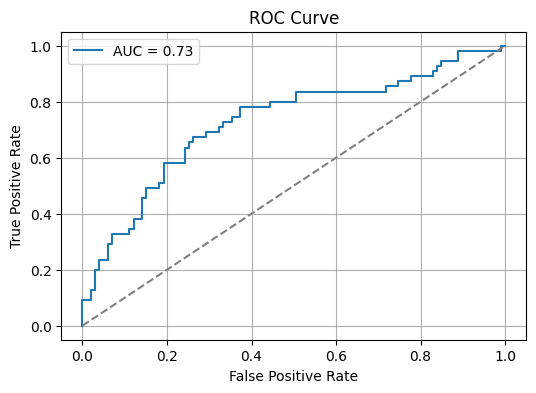

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
